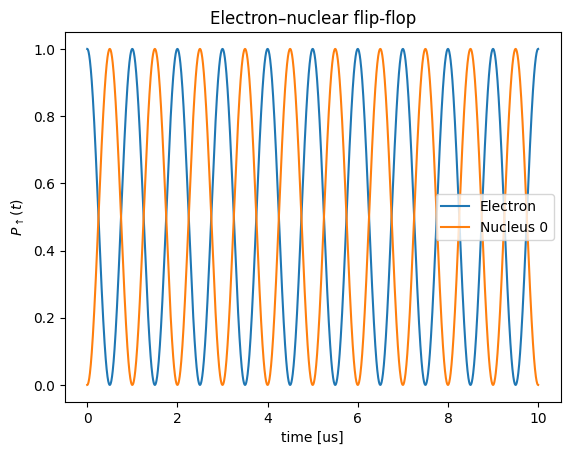

In [ ]:
import numpy as np
import qutip

# ------------------------
# Parameter
# ------------------------
MHz = 1e6
omega_eZ = 0 #2 * np.pi * 50 * MHz # Electron Zeeman frequency, 50 MHz
omega_NZ = 0 #2 * np.pi * 5 * MHz  # Nuclear Zeeman frequency, 5 MHz
n_nuclei = 1
a_j = 2 * np.pi * 0.5 * MHz # Hyperfine coupling constant, 0.5 MHz

# ------------------------
# Operator
# ------------------------
sx, sy, sz = 0.5 * qutip.sigmax(), 0.5 * qutip.sigmay(), 0.5 * qutip.sigmaz()
sp, sm = 0.5 * qutip.sigmap(), 0.5 * qutip.sigmam()

# electron operator
def e(op):
    ops = [op] + [qutip.qeye(2) for _ in range(n_nuclei)]
    return qutip.tensor(ops)

# nuclear operator k
def n(op, k):
    ops = [qutip.qeye(2) for _ in range(n_nuclei + 1)]
    ops[k+1] = op
    return qutip.tensor(ops)

# ------------------------
# Hamiltonian
# ------------------------
H_eZ = omega_eZ * e(sz)
H_NZ = omega_NZ * sum(n(sz, k) for k in range(n_nuclei))
# TODO: Move a_j inside the sum for heterogeneous coupling
H_hf = a_j * sum(e(sp) * n(sm,k) + e(sm) * n(sp,k) + e(sz) * n(sz,k) for k in range(n_nuclei))
H = H_eZ + H_NZ + H_hf

# ------------------------
# Initial State
# ------------------------
up, down = qutip.basis(2,0), qutip.basis(2,1)
psi_e0 = up
nuc_list = [down] + [up]*(n_nuclei-1)
psi_n = qutip.tensor(nuc_list)
psi0 = qutip.tensor(psi_e0, psi_n)

# ------------------------
# Time Evolution
# ------------------------
tgrid = np.linspace(0, 10e-6, 2000)  # Time grid from 0 to 10 us, 2000 points, i.e. dt = 5 ns
P_up_op = e(up * up.dag())
P_n_up_ops = [n(up * up.dag(), k) for k in range(n_nuclei)]
result = qutip.sesolve(H, psi0, tgrid, e_ops=[P_up_op] + P_n_up_ops)

P_e_up_t = result.expect[0]
P_n_up_t = result.expect[1:]

# ------------------------
# Plot
# ------------------------
import matplotlib.pyplot as plt
plt.plot(tgrid * 1e6, P_e_up_t, label="Electron")
for k in range(n_nuclei):
    plt.plot(tgrid * 1e6, P_n_up_t[k], label=f"Nucleus {k}")
plt.xlabel("time [us]")
plt.ylabel(r"$P_\uparrow(t)$")
plt.title("Electron–nuclear flip-flop")
plt.legend()
plt.show()